# Clasificador de Aves

## Librerias

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import EfficientNetV2B3, EfficientNetV2B2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, GlobalMaxPooling2D, Rescaling, Input, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.applications.efficientnet import preprocess_input

import warnings
warnings.filterwarnings("ignore")

## Datasets

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
carpeta = '/content/drive/My Drive/ProyectoFinal_RN_ClasificadorAves/Data'
archivos = os.listdir(carpeta)
print(archivos)

['train', 'test', 'valid']


In [4]:
# Paths del archivo de labels y de las carpetas train y test
train_path = '/content/drive/My Drive/ProyectoFinal_RN_ClasificadorAves/Data/train'
test_path = '/content/drive/My Drive/ProyectoFinal_RN_ClasificadorAves/Data/test'
valid_path = '/content/drive/My Drive/ProyectoFinal_RN_ClasificadorAves/Data/valid'

In [5]:
batch_size = 32
IMG_SIZE = (300, 300)

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    shuffle=True,
    image_size=IMG_SIZE,
    batch_size=batch_size,
    seed = 42
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_path,
    image_size=IMG_SIZE,
    batch_size=batch_size,
)

valid_ds = tf.keras.utils.image_dataset_from_directory(
    valid_path,
    image_size=IMG_SIZE,
    batch_size=batch_size
)

Found 84635 files belonging to 525 classes.
Found 2635 files belonging to 525 classes.
Found 2625 files belonging to 525 classes.


In [6]:
class_names = train_ds.class_names
print("Clases del conjunto de entrenamiento:", class_names)

Clases del conjunto de entrenamiento: ['ABBOTTS BABBLER', 'ABBOTTS BOOBY', 'ABYSSINIAN GROUND HORNBILL', 'AFRICAN CROWNED CRANE', 'AFRICAN EMERALD CUCKOO', 'AFRICAN FIREFINCH', 'AFRICAN OYSTER CATCHER', 'AFRICAN PIED HORNBILL', 'AFRICAN PYGMY GOOSE', 'ALBATROSS', 'ALBERTS TOWHEE', 'ALEXANDRINE PARAKEET', 'ALPINE CHOUGH', 'ALTAMIRA YELLOWTHROAT', 'AMERICAN AVOCET', 'AMERICAN BITTERN', 'AMERICAN COOT', 'AMERICAN DIPPER', 'AMERICAN FLAMINGO', 'AMERICAN GOLDFINCH', 'AMERICAN KESTREL', 'AMERICAN PIPIT', 'AMERICAN REDSTART', 'AMERICAN ROBIN', 'AMERICAN WIGEON', 'AMETHYST WOODSTAR', 'ANDEAN GOOSE', 'ANDEAN LAPWING', 'ANDEAN SISKIN', 'ANHINGA', 'ANIANIAU', 'ANNAS HUMMINGBIRD', 'ANTBIRD', 'ANTILLEAN EUPHONIA', 'APAPANE', 'APOSTLEBIRD', 'ARARIPE MANAKIN', 'ASHY STORM PETREL', 'ASHY THRUSHBIRD', 'ASIAN CRESTED IBIS', 'ASIAN DOLLARD BIRD', 'ASIAN GREEN BEE EATER', 'ASIAN OPENBILL STORK', 'AUCKLAND SHAQ', 'AUSTRAL CANASTERO', 'AUSTRALASIAN FIGBIRD', 'AVADAVAT', 'AZARAS SPINETAIL', 'AZURE BREASTED P

### Visualización

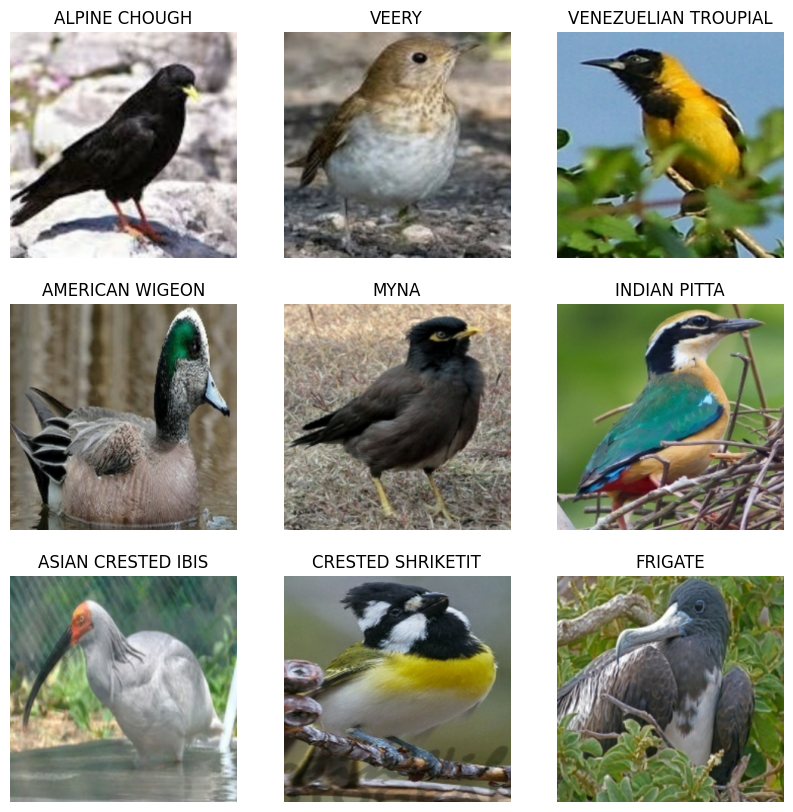

In [7]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Model

In [27]:
IMG_SHAPE= IMG_SIZE + (3,)
base_model = EfficientNetV2B3(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet',
    include_preprocessing=False
)

base_model.trainable = False

model = Sequential([
    Input(shape=IMG_SHAPE),
    Rescaling(1./255, input_shape=IMG_SHAPE),
    base_model,
    GlobalMaxPooling2D(name = 'max_pooling'),
    BatchNormalization(name = 'batch_norm'),
    Dense(len(class_names), activation='softmax')
])

In [50]:
IMG_SHAPE

(300, 300, 3)

In [28]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 300, 300, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b3 (Functional)       │ (None, 10, 10, 1536)        │      12,930,622 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling (GlobalMaxPooling2D)     │ (None, 1536)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_norm (BatchNormalization)      │ (None, 1536)                │           6,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 525)                 │         806,925 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,743,691 (52.43 MB)

 Trainable params: 809,997 (3.09 MB)

 Non-trainable params: 12,933,694 (49.34 MB)

In [29]:
base_learning_rate = 0.0001
model.compile(loss='sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 300, 300, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b3 (Functional)       │ (None, 10, 10, 1536)        │      12,930,622 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling (GlobalMaxPooling2D)     │ (None, 1536)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_norm (BatchNormalization)      │ (None, 1536)                │           6,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 525)                 │         806,925 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,743,691 (52.43 MB)

 Trainable params: 809,997 (3.09 MB)

 Non-trainable params: 12,933,694 (49.34 MB)

In [31]:
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=5,
                               restore_best_weights=True,
                               min_delta=0.001)

In [32]:
%time history = model.fit(train_ds, epochs=25, validation_data=valid_ds, callbacks=[early_stopping])

Epoch 1/25
2645/2645 ━━━━━━━━━━━━━━━━━━━━ 260s 74ms/step - accuracy: 0.2421 - loss: 4.2789 - val_accuracy: 0.8168 - val_loss: 0.9099
Epoch 2/25
2645/2645 ━━━━━━━━━━━━━━━━━━━━ 137s 52ms/step - accuracy: 0.7260 - loss: 1.2838 - val_accuracy: 0.8872 - val_loss: 0.5052
Epoch 3/25
2645/2645 ━━━━━━━━━━━━━━━━━━━━ 138s 52ms/step - accuracy: 0.8103 - loss: 0.8462 - val_accuracy: 0.9135 - val_loss: 0.3818
Epoch 4/25
2645/2645 ━━━━━━━━━━━━━━━━━━━━ 139s 53ms/step - accuracy: 0.8517 - loss: 0.6520 - val_accuracy: 0.9269 - val_loss: 0.3218
Epoch 5/25
2645/2645 ━━━━━━━━━━━━━━━━━━━━ 138s 52ms/step - accuracy: 0.8742 - loss: 0.5381 - val_accuracy: 0.9242 - val_loss: 0.2871
Epoch 6/25
2645/2645 ━━━━━━━━━━━━━━━━━━━━ 138s 52ms/step - accuracy: 0.8906 - loss: 0.4612 - val_accuracy: 0.9330 - val_loss: 0.2680
Epoch 7/25
2645/2645 ━━━━━━━━━━━━━━━━━━━━ 139s 52ms/step - accuracy: 0.9037 - loss: 0.4022 - val_accuracy: 0.9352 - val_loss: 0.2517
Epoch 8/25
2645/2645 ━━━━━━━━━━━━━━━━━━━━ 138s 52ms/step - accuracy: 

In [33]:
model.save("model.h5")

In [34]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - accuracy: 0.9648 - loss: 0.1193
Test accuracy : 0.9650853872299194


In [35]:
# Guardar el modelo en Google Drive
model.save("/content/drive/My Drive/ProyectoFinal_RN_ClasificadorAves/model/model.h5")

# Guardar el historial de entrenamiento en Google Drive
with open("/content/drive/My Drive/ProyectoFinal_RN_ClasificadorAves/model/history.json", "w") as json_file:
    json.dump(history.history, json_file)

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

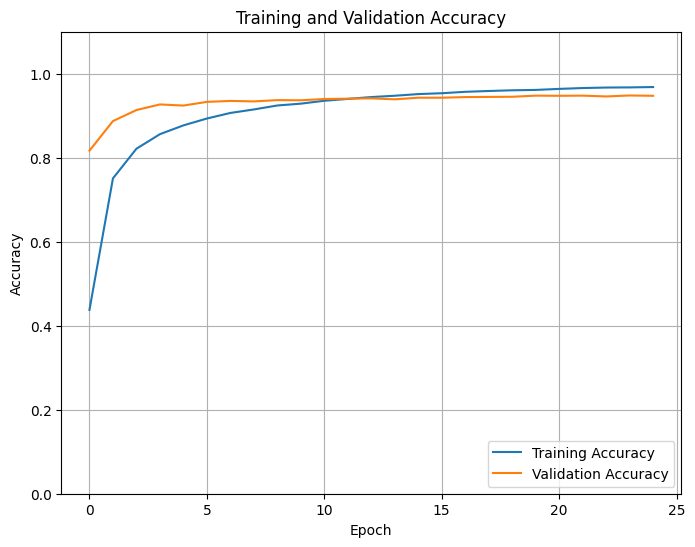

In [37]:
plt.figure(figsize=(8, 6))
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.grid(True)
plt.ylim([0, 1.1])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.savefig('/content/drive/My Drive/ProyectoFinal_RN_ClasificadorAves/model/accuracy.png')
plt.show()

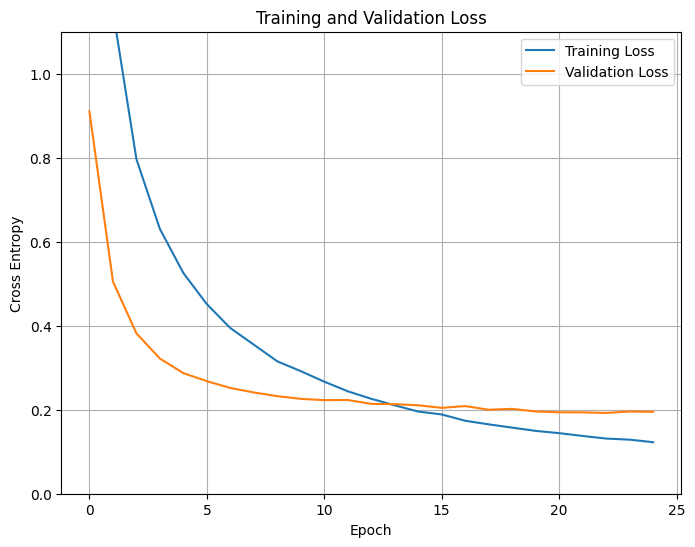

In [38]:
plt.figure(figsize=(8, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.1])
plt.grid(True)
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.savefig('/content/drive/My Drive/ProyectoFinal_RN_ClasificadorAves/model/Loss.png')
plt.show()

# TensorflowJS

In [39]:
!pip install tensorflowjs

In [43]:
# Ruta a la carpeta birds_classification en Google Drive
data_folder = '/content/drive/My Drive/ProyectoFinal_RN_ClasificadorAves/model'

# Listar archivos en la carpeta
files = os.listdir(data_folder)
print("Archivos en /ProyectoFinal_RN_ClasificadorAves/model:", files)

Archivos en /ProyectoFinal_RN_ClasificadorAves/model: ['model.h5', 'history.json', 'accuracy.png', 'Loss.png']


In [44]:
!cp '/content/drive/MyDrive/ProyectoFinal_RN_ClasificadorAves/model/model.h5' /content/

In [46]:
!mkdir carpeta_salida

In [47]:
!tensorflowjs_converter --input_format keras model.h5 carpeta_salida

2024-05-01 05:33:34.530943: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
failed to lookup keras version from the file,
    this is likely a weight only file


In [48]:
!ls carpeta_salida

group1-shard10of14.bin	group1-shard14of14.bin	group1-shard4of14.bin  group1-shard8of14.bin
group1-shard11of14.bin	group1-shard1of14.bin	group1-shard5of14.bin  group1-shard9of14.bin
group1-shard12of14.bin	group1-shard2of14.bin	group1-shard6of14.bin  model.json
group1-shard13of14.bin	group1-shard3of14.bin	group1-shard7of14.bin


In [49]:
!zip -r model.zip /content/carpeta_salida/

updating: content/carpeta_salida/ (stored 0%)
updating: content/carpeta_salida/model.json (deflated 97%)
  adding: content/carpeta_salida/group1-shard1of14.bin (deflated 7%)
  adding: content/carpeta_salida/group1-shard14of14.bin (deflated 8%)
  adding: content/carpeta_salida/group1-shard12of14.bin (deflated 8%)
  adding: content/carpeta_salida/group1-shard5of14.bin (deflated 8%)
  adding: content/carpeta_salida/group1-shard8of14.bin (deflated 8%)
  adding: content/carpeta_salida/group1-shard2of14.bin (deflated 7%)
  adding: content/carpeta_salida/group1-shard10of14.bin (deflated 8%)
  adding: content/carpeta_salida/group1-shard7of14.bin (deflated 8%)
  adding: content/carpeta_salida/group1-shard11of14.bin (deflated 8%)
  adding: content/carpeta_salida/group1-shard13of14.bin (deflated 8%)
  adding: content/carpeta_salida/group1-shard3of14.bin (deflated 8%)
  adding: content/carpeta_salida/group1-shard4of14.bin (deflated 8%)
  adding: content/carpeta_salida/group1-shard9of14.bin (deflat